# [Solved] Lab 4: Effect of **data augmentation** on a *shallow, linear FCN*

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/solutions/AdvML_UniTS_2023_Lab_04_FCN_Augmentation_Solved.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### High-level overview

In the *Lab* that follows, we will explore the effect of **data augmentation** on the structure of learned weights in a *neural network* model. As an example, we will consider a *shallow, linear FCN* (fully-connected network with just 1 layer and no non-linearities) that is trained on the MNIST *classification task*.

On a high level, you need to:
- Define and train a *shallow, linear FCN* on the MNIST dataset, using *training-set augmentation* by means of *random rotations*;
- Extract the learned weights from the trained model;
- Visualize the learned weights as *images* and comment on their structure.

The rest of the notebook will guide you through more detailed steps you need to follow.

In [1]:
import os

from tqdm.auto import trange

import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

#### Loading the datasets and defining augmentation strategies

Load the (training and test) *MNIST* datasets as we did in the previous lab, with the following meaningful differences:
- Apply random rotations to the dataset used for training, using a rotation range of $[0, 180]$ degrees.
- Apply normalization to both datasets, using a mean of $0.1307$ and a standard deviation of $0.3081$ (they are notable, pre-computed values for the MNIST **training** dataset);

**Hint**: look up the documentation for the `transforms.RandomRotation` and `transforms.Normalize` classes.

**Optional**: Visualize the augmented training dataset, to get a sense of the effect of the augmentation strategy.

In [2]:
# The same plotting function from the previous lab
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0

In [4]:
# Defining transforms
augmentation = transforms.RandomAffine(degrees=(0, 180), translate=None, scale=None)
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.1307, std=0.3081)

# Loading the datasets
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([augmentation, to_tensor, normalization]),
    download=True,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


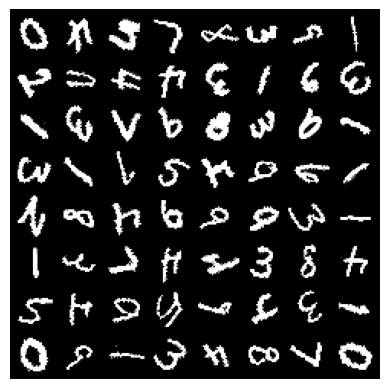

In [5]:
# Visualizing the augmented training dataset
# Same as in previous lab

dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images))

#### Model definition and training

Define the model and train it on the classification task, as we did in the previous *Lab*. Use fixed-learning-rate *Stochastic Gradient Descent* (with no momentum) as the optimizer. Feel free to experiment with the other hyperparameters.

**Optional**: Plot the training loss as the training progresses. Show also test loss at the beginning and at the end of training.


In [6]:
# Model definition
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)  # More numerically stable than softmax
        return x

In [7]:
# Model instantiation
model = MyModel()

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

criterion = nn.NLLLoss()

Using device: cuda


In [8]:
# Some useful functions
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [9]:
# Get test stats before training
model = model.eval()
untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)
model = model.train()

In [10]:
# Training loop

batch_losses = []

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

# Saving weights
dirname = "models/"
if not os.path.exists(dirname):
    os.makedirs(dirname)
th.save(model.state_dict(), dirname + "rotation_invariant_slfcn.pth")

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# Get test stats after training
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

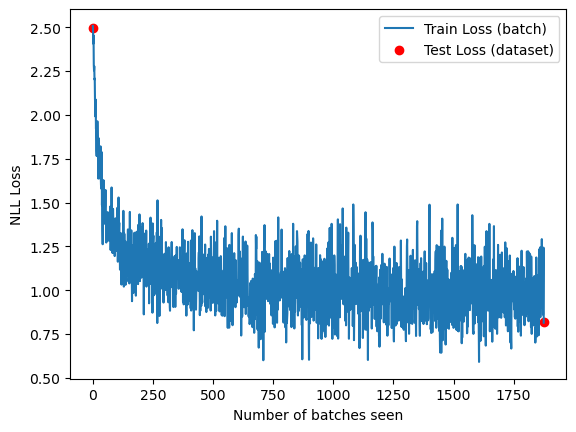

In [12]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ = plt.scatter((xrange[0], xrange[-1]), (untrained_loss, trained_loss), color="red")
_ = plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

#### Weights extraction and visualization

Extract the tensors corresponding to learned weights from the trained model (they are stored as the `weights` attribute of the linear layer), and visualize them as images.

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.

**Remark**: in order to be able to visualize the weights as images, they need to be appropriately scaled (as tensor) within the $[0,1]$ range.


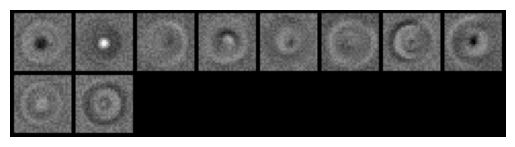

In [13]:
# Extracting weights
weights = model.fc.weight.detach().cpu()

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)

# Plot
plt_weights = plt_weights.reshape(plt_weights.shape[0], -1, 28, 28)
imshow(torchvision.utils.make_grid(plt_weights))

#### Optional I: Training with different augmentation strategies

Repeat the same process described above, but using different augmentation strategy, namely:
- Apply a central (vertical or horizontal, one only or both) flip to images in the training dataset;
- Apply random traslations to images in the training dataset, bound by an arbitrary maximum;

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.


#### Optional II: Testing for the invariance of the learned representation

Test that the internal representation produced by the weights learned under data augmentation is indeed invariant to the same transformation used for data augmentation. You may follow the guidance given in [this notebook](AdvML_UniTS_2023_Lab_04bis_FCN_Invariance_Solved.ipynb).
